In [198]:
from copy import deepcopy
from dataclasses import dataclass
from enum import Enum
from math import inf, sqrt, e, factorial, lcm
from typing import Any, Callable, List, Optional, Tuple
from fractions import Fraction

import matplotlib.pyplot as plot
import numpy as np
from IPython.display import Latex, display_latex


# Constantes

In [199]:
MAX_ITER_PADRAO = 100
DELTA_DERIVACAO_PADRAO = 10**-4
DERIVADA_SPLINE_PADRAO = 0
GRAU_SPLINE_PADRAO = 2
INDICE_SPLINE_PADRAO = 0
FORMATO_PADRAO = ".8g"


# Básico


In [200]:
def polinomio(coefs: List[float]) -> Callable[[float], float]:
    coefs = deepcopy(coefs)
    return lambda x: sum(coefs[i] * x**i for i in range(len(coefs)))


def lerp(a: float, b: float, x: float) -> float:
    return a * (1 - x) + b * x


def amostras(
    f: Callable[[float], float],
    a: float,
    b: float,
    n: int = 50,
) -> Tuple[List[float], List[float]]:
    assert n >= 2, "mínimo de dois pontos de amostragem"
    xs = [lerp(a, b, i / (n - 1)) for i in range(n)]
    ys = [f(x) for x in xs]
    return xs, ys


def amostras_em_torno(
    f: Callable[[float], float],
    x: float,
    pontos: List[int],
    delta=DELTA_DERIVACAO_PADRAO,
) -> List[float]:
    return [f(x + p * delta) for p in pontos]


def numeradores_denominador_comum(valores: List[float]) -> Tuple[List[float], float]:
    ns, ds = [], []
    for v in valores:
        f = Fraction(v).limit_denominator()
        ns.append(f.numerator)
        ds.append(f.denominator)
    denominador = lcm(*ds)
    ns = [round(n * (denominador / d), ndigits=0) for n, d in zip(ns, ds)]
    return ns, denominador


# Métodos iterativos

## Calculo do erro

In [201]:
def erro_absoluto(referencia: float, estimativa: float) -> float:
    return abs(referencia - estimativa)


def erro_relativo(referencia: float, estimativa: float) -> float:
    return abs((referencia - estimativa) / estimativa)


## Classes de estado

In [202]:
@dataclass
class EstadoAB:

    f: Callable[[float], float]
    i: int
    a: float
    b: float
    x_ant: Optional[float]
    x: float
    y: float

    def __init__(
        self, f: Callable[[float], float], a: float, b: float, x: float, y: float
    ) -> None:
        self.f = f
        self.i: int = 1
        self.a = a
        self.b = b
        self.x_ant = None
        self.x = x
        self.y = y

    def __str__(self) -> str:
        return f"iteracao: {self.i}, a: {self.a}, b: {self.b}, x: {self.x}, y: {self.y}"


In [203]:
@dataclass
class EstadoX:

    f: Callable[[float], float]
    fi: Callable[[float], float]
    i: int
    x_ant: Optional[float]
    x: float
    y: float

    def __init__(
        self,
        f: Callable[[float], float],
        fi: Callable[[float], float],
        x: float,
        y: float,
    ) -> None:
        self.f = f
        self.fi = fi
        self.i: int = 1
        self.x_ant = None
        self.x = x
        self.y = y

    def __str__(self) -> str:
        return f"iteracao: {self.i}, x: {self.x}, y:{self.y}"


## Método da bisseção

In [204]:
def bissecao(
    f: Callable[[float], float],
    a: float,
    b: float,
    criterios: list[Callable[[EstadoAB], bool]],
    observador: Callable[[EstadoAB], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    a, b = sorted([a, b])
    x = (a + b) / 2
    est = EstadoAB(f, a, b, x, f(x))
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        est.i += 1
        if f(est.a) * est.y < 0:
            est.b = est.x
        else:
            est.a = est.x
        est.x_ant = est.x
        est.x = (est.a + est.b) / 2
        est.y = f(est.x)
        observador(est)
    return est


## Método da falsa posição

In [205]:
def falsa_posicao(
    f: Callable[[float], float],
    a: float,
    b: float,
    criterios: list[Callable[[EstadoAB], bool]],
    observador: Callable[[EstadoAB], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    a, b = sorted([a, b])
    x = (a * f(b) - b * f(a)) / (f(b) - f(a))
    est = EstadoAB(f, a, b, x, f(x))
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        est.i += 1
        if f(est.a) * est.y < 0:
            est.b = est.x
        else:
            est.a = est.x
        est.x_ant = est.x
        est.x = (est.a * f(est.b) - est.b * f(est.a)) / (f(est.b) - f(est.a))
        est.y = f(est.x)
        observador(est)
    return est


## Método do ponto fixo

In [206]:
def ponto_fixo(
    f: Callable[[float], float],
    fi: Callable[[float], float],
    x: float,
    criterios: list[Callable[[EstadoX], bool]],
    observador: Callable[[EstadoX], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    est = EstadoX(f, fi, x, f(x))
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        est.i += 1
        est.x_ant = est.x
        est.x = fi(est.x)
        est.y = f(est.x)
        observador(est)
    return est


## Método de Newton-Raphson

In [207]:
def newton_raphson(
    f: Callable[[float], float],
    d: Callable[[float], float],
    x: float,
    criterios: List[Callable[[EstadoX], bool]],
    observador: Callable[[EstadoX], None] = lambda x: None,
    max_iter=MAX_ITER_PADRAO,
):
    fi = lambda x: x - f(x) / d(x)
    return ponto_fixo(f, fi, x, criterios, observador, max_iter)


# Sistemas lineares

## Pivotamento

In [208]:
def _busca_pivo(linha: int, coluna: int, b: List[List[float]]):
    maior = -inf
    posicao = -1
    for l in range(linha, len(b)):
        valor = abs(b[l][coluna])
        if valor > maior:
            maior = valor
            posicao = l
    return posicao


def _pivotar_em(
    linha: int,
    coluna: int,
    b: List[List[float]],
    y: Optional[List[float]] = None,
) -> bool:
    linha_pivo = _busca_pivo(linha, coluna, b)
    if linha_pivo != -1:
        b[linha], b[linha_pivo] = b[linha_pivo], b[linha]
        if y is not None:
            y[linha], y[linha_pivo] = y[linha_pivo], y[linha]
        return True
    else:
        return False


def pivotar(b: List[List[float]], y: Optional[List[float]] = None):
    b = deepcopy(b)
    y = deepcopy(y)
    l, c = 0, 0
    m, n = len(b), len(b[0])
    while l < m and c < n:
        if _pivotar_em(l, c, b, y):
            l += 1
        c += 1
    return b, y


## Método de Gauss

In [209]:
def _multiplicar_somar(
    fator: float,
    ori: int,
    dest: int,
    b: List[List[float]],
    y: Optional[List[float]] = None,
):
    colunas = len(b[0])
    for c in range(colunas):
        b[dest][c] += fator * b[ori][c]
    if y is not None:
        y[dest] += fator * y[ori]
    pass


def _elimininacao_gauss(
    linha: int,
    coluna: int,
    b: List[List[float]],
    y: Optional[List[float]] = None,
):
    for l in range(linha + 1, len(b)):
        fator = b[l][coluna] / b[linha][coluna]
        _multiplicar_somar(-fator, linha, l, b, y)


def gauss(
    b: List[List[float]],
    y: Optional[List[float]] = None,
) -> Tuple[List[List[float]], Optional[List[float]]]:
    b, y = deepcopy(b), deepcopy(y)
    l, c = 0, 0
    m, n = len(b), len(b[0])
    while l < m and c < n:
        if _pivotar_em(l, c, b, y):
            _elimininacao_gauss(l, c, b, y)
            l += 1
        c += 1
    return b, y


## Tipo Solução

In [210]:
class TipoSolucao(Enum):
    NENHUMA = 0
    UNICA = 1
    MULTIPLAS = 2


def tipo_solucao(b, y) -> TipoSolucao:
    for i in range(len(b)):
        if b[i][i] == 0.0:
            if y[i] == 0.0:
                return TipoSolucao.MULTIPLAS
            else:
                return TipoSolucao.NENHUMA
    return TipoSolucao.UNICA


## Substituição Retroativa

In [211]:
def substituicao_retroativa(b: List[List[float]], y: List[float]) -> List[float]:
    if tipo_solucao(b, y) != TipoSolucao.UNICA:
        raise ValueError("a matriz dada não admite solução unica")
    n = len(y)
    x = [0.0] * n
    for i in reversed(range(n)):
        s = sum(b[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (y[i] - s) / b[i][i]
    return x


## Solucionar sistema

In [212]:
def solucionar_linear(b: List[List[float]], y: List[float]):
    b, y = gauss(b, y)  # type: ignore
    x = substituicao_retroativa(b, y)
    return x


## Gauss-Seidel

In [213]:
@dataclass
class EstadoGauss:

    i: int
    x_ant: Optional[List[float]]
    x: List[float]

    def __init__(self, x: List[float]) -> None:
        self.i = 1
        self.x_ant = None
        self.x = x


In [214]:
def _passo_gauss_seidel(
    b: List[List[float]],
    y: List[float],
    x: List[float],
) -> List[float]:
    n = len(x)
    proximo_x = [0.0] * n
    for i in range(n):
        soma_esquerda = sum(b[i][j] * x[j] for j in range(i))
        soma_direita = sum(b[i][j] * x[j] for j in range(i + 1, n))
        proximo_x[i] = (y[i] - soma_esquerda - soma_direita) / b[i][i]
    return proximo_x


def gauss_seidel(
    b: List[List[float]],
    y: List[float],
    x_inicial: List[float],
    criterios: List[Callable[[EstadoGauss], bool]],
    observador: Callable[[EstadoGauss], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
) -> EstadoGauss:
    estado = EstadoGauss(deepcopy(x_inicial))
    while not all(c(estado) for c in criterios) and estado.i < max_iter:
        estado.i += 1
        estado.x_ant = estado.x
        estado.x = _passo_gauss_seidel(b, y, estado.x)
    return estado


## Gauss-Jacob

In [215]:
def _passo_gauss_jacob(
    b: List[List[float]],
    y: List[float],
    x: List[float],
) -> List[float]:
    n = len(x)
    proximo_x = [0.0] * n
    for i in range(n):
        soma_esquerda = sum(b[i][j] * proximo_x[j] for j in range(i))
        soma_direita = sum(b[i][j] * x[j] for j in range(i + 1, n))
        proximo_x[i] = (y[i] - soma_esquerda - soma_direita) / b[i][i]
    return proximo_x


def gauss_jacob(
    b: List[List[float]],
    y: List[float],
    x_inicial: List[float],
    criterios: List[Callable[[EstadoGauss], bool]],
    observador: Callable[[EstadoGauss], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
) -> EstadoGauss:
    estado = EstadoGauss(deepcopy(x_inicial))
    while not all(c(estado) for c in criterios) and estado.i < max_iter:
        estado.i += 1
        estado.x_ant = estado.x
        estado.x = _passo_gauss_jacob(b, y, estado.x)
    return estado


# Interpolação

## Polinômio de Lagrange

In [216]:
from math import prod


def _termo_lagrange(xs: List[float], ys: List[float], x: float, i: int) -> float:
    n = len(xs)
    produto_superior = prod(x - xs[j] for j in range(n) if j != i)
    produto_inferior = prod(xs[i] - xs[j] for j in range(n) if j != i)
    return (produto_superior / produto_inferior) * ys[i]


def polinomio_lagrange(xs: List[float], ys: List[float]) -> Callable[[float], float]:
    xs = deepcopy(xs)
    ys = deepcopy(ys)
    return lambda x: sum(_termo_lagrange(xs, ys, x, i) for i in range(len(xs)))


## Polinômio de Newton

In [217]:
def coeficientes_polinomio_newton(xs: List[float], ys: List[float]) -> List[float]:
    assert len(xs) == len(ys), "xs e ys devem ter o mesmo comprimento"
    n = len(xs)
    m = [[0.0] * (n - i) for i in range(n)]
    for i in range(n):
        m[i][0] = ys[i]
    for j in range(1, n):
        for i in range(n - j):
            m[i][j] = (m[i + 1][j - 1] - m[i][j - 1]) / (xs[i + j] - xs[i])
    return m[0]


def _termo_newton(xs: List[float], coefs: List[float], x: float, i: int) -> float:
    return coefs[i] * prod(x - xs[j] for j in range(i))


def polinomio_newton(xs: List[float], coefs: List[float]):
    xs = deepcopy(xs)
    coefs = deepcopy(coefs)
    return lambda x: sum(_termo_newton(xs, coefs, x, i) for i in range(len(xs)))


## Spline quadrática

In [218]:
_ESQUERDA = 0
_DIREITA = 1


def _linha(x: float, grau: int = 0) -> List[float]:
    match grau:
        case 0:
            return [1.0, x, x**2]
        case 1:
            return [0, 1.0, 2 * x]
        case 2:
            return [0.0, 0.0, 2.0]
        case _:
            raise ValueError(f"valor de grau {grau} invalido")


def _valor_derivada(coefs: List[float], x: float) -> float:
    return sum(i * x ** (i - 1) * coefs[i] for i in range(1, len(coefs)))


def _segmento_spline(
    xs: List[float],
    ys: List[float],
    derivada: float,
    grau: int,
    indice: int,
    lado: int,
) -> List[float]:
    x = [
        _linha(xs[indice]),
        _linha(xs[indice + 1]),
        _linha(xs[indice + lado], grau),
    ]
    y = [ys[indice], ys[indice + 1], derivada]
    return solucionar_linear(x, y)


def coeficientes_spline_quadratica(
    xs: List[float],
    ys: List[float],
    derivada: float = DERIVADA_SPLINE_PADRAO,
    grau: int = GRAU_SPLINE_PADRAO,
    indice: int = INDICE_SPLINE_PADRAO,
) -> List[List[float]]:
    assert len(xs) == len(ys), "xs e ys devem ter o mesmo comprimento"
    assert grau in [1, 2], "grau inválido"
    assert 0 <= indice, "indice não pode ser menor que 0"
    assert indice < len(xs), "indice não pode ser menor que len(ys)"
    lista_coefs: List[List[float]] = [[]] * (len(xs) - 1)
    # Resolve os coeficientes para as funções a esquerda
    d = derivada
    g = grau
    for i in range(indice - 1, -1, -1):
        coefs = _segmento_spline(xs, ys, d, g, i, _DIREITA)
        lista_coefs[i] = coefs
        d = _valor_derivada(coefs, xs[i])
        g = 1
    # Resolve os coeficientes para as funções a direita
    if indice == 0:
        d = derivada
        g = grau
    else:
        d = _valor_derivada(lista_coefs[indice - 1], xs[indice])
        g = 1
    for i in range(indice, len(xs) - 1):
        coefs = _segmento_spline(xs, ys, d, g, i, _ESQUERDA)
        lista_coefs[i] = coefs
        d = _valor_derivada(coefs, xs[i + 1])
        g = 1
    return lista_coefs


def spline_quadratica(
    xs: List[float], lista_coefs: List[List[float]]
) -> Callable[[float], float]:
    xs = deepcopy(xs)
    lista_coefs = deepcopy(lista_coefs)
    fs = [polinomio(coefs) for coefs in lista_coefs]

    def interpolador(x):
        for i in range(len(xs) - 1):
            if x < xs[i + 1]:
                return fs[i](x)
        return fs[-1](x)

    return interpolador


# Ajuste de curvas

## Minimos quadrados

In [219]:
def _produto_escalar(a: List[float], b: List[float]):
    return sum(i * j for i, j in zip(a, b))


def coeficientes_minimos_quadrados(
    xs: List[float],
    ys: List[float],
    fs: List[Callable[[float], float]],
) -> List[float]:
    assert len(xs) == len(ys), "xs e ys devem ter o mesmo comprimento"
    n = len(fs)
    gs = [[f(x) for x in xs] for f in fs]
    b = [[_produto_escalar(gs[i], gs[j]) for i in range(n)] for j in range(n)]
    y = [_produto_escalar(gs[i], ys) for i in range(n)]
    return solucionar_linear(b, y)


def minimos_quadrados(
    fs: List[Callable[[float], float]],
    coefs: List[float],
):
    coefs = deepcopy(coefs)
    return lambda x: sum(c * f(x) for c, f in zip(coefs, fs))


def soma_quadrado_residuos(
    xs: List[float],
    ys: List[float],
    f: Callable[[float], float],
) -> float:
    return sum((y - f(x)) ** 2 for x, y in zip(xs, ys))


# Condições de parada

In [220]:
def limite_iteracao(i: int) -> Callable[[Any], bool]:
    return lambda est: est.i >= i


def criterio_erro_absoluto(
    ref: float,
    erro_max: float,
) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: erro_absoluto(ref, est.x) < erro_max


def criterio_ab(erro_max: float) -> Callable[[EstadoAB], bool]:
    return lambda est: est.b - est.a < 2 * erro_max


def criterio_x(erro_max: float) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: est.f(est.x - erro_max) * est.f(est.x + erro_max) < 0


def criterio_delta_x(delta: float) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: est.x_ant is not None and abs(est.x - est.x_ant) < delta


def criterio_y(dist_zero: float) -> Callable[[EstadoAB | EstadoX], bool]:
    return lambda est: abs(est.y) < dist_zero


def criterio_delta_x_vetor(delta: float) -> Callable[[EstadoGauss], bool]:
    return lambda est: est.x_ant is not None and all(
        (abs(i - j) < delta) for i, j in zip(est.x_ant, est.x)
    )


# Diferenciação numérica

In [221]:
def diferenca_finita(
    h: float, ordem: int, coefs: List[float], divisor: float, ys: List[float]
) -> float:
    assert len(coefs) == len(ys), "tamanho de coefs e ys devem ser iguais"
    return sum(c * y for c, y in zip(coefs, ys)) / (divisor * h**ordem)


def coeficientes_diferenca(
    pontos: List[int], ordem: int, ajustar: bool = True
) -> Tuple[List[float], float]:
    assert ordem >= 1, "ordem deve ser no mínimo 1"
    assert len(pontos) > ordem, "o numero de pontos deve ser maior que a ordem"
    n = len(pontos)
    b = [[p**i for p in pontos] for i in range(n)]
    y = [0.0] * n
    y[ordem] = factorial(ordem)
    coefs = solucionar_linear(b, y)
    if ajustar:
        return numeradores_denominador_comum(coefs)
    else:
        return coefs, 1.0


def ordem_erro_diferenca(numero_pontos: int, ordem: int) -> int:
    return numero_pontos - ordem


# Derivação numérica

In [222]:
def derivada_direita(
    f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO
) -> Callable[[float], float]:
    return lambda x: (f(x + delta) - f(x)) / delta


def derivada_esquerda(
    f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO
) -> Callable[[float], float]:
    return lambda x: (f(x - delta) - f(x)) / delta


def derivada_central(
    f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO
) -> Callable[[float], float]:
    return lambda x: (f(x + delta) - f(x - delta)) / (2 * delta)


def derivada_numerica(
    f: Callable,
    pontos: List[int],
    ordem: int,
    delta=DELTA_DERIVACAO_PADRAO,
) -> Callable[[float], float]:
    coefs, divisor = coeficientes_diferenca(pontos, ordem)

    def derivada(x: float):
        ys = amostras_em_torno(f, x, pontos, delta)
        return diferenca_finita(delta, ordem, coefs, divisor, ys)

    return derivada


# Integração numérica

## Método composto

In [223]:
def integracao_composta(
    f: Callable[[float], float],
    integrador: Callable[[Callable[[float], float], float, float], float],
    a: float,
    b: float,
    n: int,
) -> float:
    assert n >= 1, "n deve ser no mínimo 1"
    h = (b - a) / n
    return sum(integrador(f, x, x + h) for x in (lerp(a, b, i / n) for i in range(n)))


## Método do retângulo

In [224]:
def integracao_retangulo_esquerda(f: Callable[[float], float], a: float, b: float):
    return f(a) * (b - a)


def integracao_retangulo_direita(f: Callable[[float], float], a: float, b: float):
    return f(b) * (b - a)


def integracao_retangulo_esquerda_composta(
    f: Callable[[float], float], a: float, b: float, n: int
) -> float:
    return integracao_composta(f, integracao_retangulo_esquerda, a, b, n)


def integracao_retangulo_direita_composta(
    f: Callable[[float], float], a: float, b: float, n: int
) -> float:
    return integracao_composta(f, integracao_retangulo_direita, a, b, n)


def estimar_erro_integracao_retangulo(
    a: float, b: float, max_1_der: float, h: Optional[float] = None
) -> float:
    if h is None:
        h = b - a
    return (b - a) / 2 * max_1_der * h


def espacamento_integracao_retangulo(
    a: float, b: float, max_1_der: float, erro: float
) -> float:
    return (2 * erro) / ((b - a) * max_1_der)


## Método do ponto central

In [225]:
def integracao_central(f: Callable[[float], float], a: float, b: float):
    return f((a + b) / 2) * (b - a)


def integracao_central_composta(
    f: Callable[[float], float], a: float, b: float, n: int
) -> float:
    return integracao_composta(f, integracao_central, a, b, n)


def estimar_erro_integracao_central(
    a: float, b: float, max_2_der: float, h: Optional[float] = None
) -> float:
    if h is None:
        h = b - a
    return (b - a) / 24 * max_2_der * h**2


def espacamento_integracao_central(
    a: float, b: float, max_2_der: float, erro: float
) -> float:
    return sqrt((24 * erro) / ((b - a) * max_2_der))


## Método do trapézio

In [226]:
def integracao_trapezio(f: Callable[[float], float], a: float, b: float):
    return (f(a) + f(b)) / 2 * (b - a)


def integracao_trapezio_composta(
    f: Callable[[float], float], a: float, b: float, n: int
):
    return integracao_composta(f, integracao_trapezio, a, b, n)


def estimar_erro_integracao_trapezio(
    a: float, b: float, max_2_der: float, h: Optional[float] = None
) -> float:
    if h is None:
        h = b - a
    return (b - a) / 12 * max_2_der * h**2


def espacamento_integracao_trapezio(
    a: float, b: float, max_2_der: float, erro: float
) -> float:
    return sqrt((12 * erro) / ((b - a) * max_2_der))


## Método de Simpson $1/3$

In [227]:
def integracao_simpson_1_3(f: Callable[[float], float], a: float, b: float):
    h = (b - a) / 2
    return (h / 3) * (f(a) + 4 * f((a + b) / 2) + f(b))


def integracao_simpson_1_3_composta(
    f: Callable[[float], float], a: float, b: float, n: int
) -> float:
    assert n % 2 == 0, "n deve ser par"
    assert n >= 2, "n deve ser no mínimo 2"
    return integracao_composta(f, integracao_simpson_1_3, a, b, n // 2)


def estimar_erro_simpson_1_3(
    a: float, b: float, max_4_der: float, h: Optional[float] = None
) -> float:
    if h is None:
        h = b - a
    return (b - a) / 180 * max_4_der * h**4


def espacamento_integracao_simpson_1_3(
    a: float, b: float, max_4_der: float, erro: float
) -> float:
    return ((180 * erro) / ((b - a) * max_4_der)) ** (1 / 4)


# Formulas

In [228]:
def _pos_processar_formula(formula: str) -> str:
    return (
        formula.replace("=+", "=")
        .replace("(+", "(")
        .replace("++", "+")
        .replace("+-", "-")
        .replace("-+", "-")
        .replace("--", "-")
    )


def _formula_termo_polinomio(coeficiente: float, potencia: int, formato: str) -> str:
    if potencia == 0:
        return f"{coeficiente:{formato}}"
    elif potencia == 1:
        return f"{coeficiente:{formato}}x"
    else:
        return f"{coeficiente:{formato}}x^{potencia}"


def formula_polinomio(coefs: List[float], formato=FORMATO_PADRAO) -> str:
    formula = "+".join(
        _formula_termo_polinomio(coefs[i], i, formato)
        for i in reversed(range(len(coefs)))
    )
    return _pos_processar_formula(formula)


def formula_polinomio_newton(
    xs: List[float],
    coefs: List[float],
    formato=FORMATO_PADRAO,
) -> str:
    formula = "+".join(
        f"{coefs[i]:{formato}}" + "".join(f"(x-{xs[j]:{formato}})" for j in range(i))
        for i in range(len(coefs))
    )
    return _pos_processar_formula(formula)


def formula_minimos_quadrados(coefs: List[float], formato=FORMATO_PADRAO) -> str:
    formula = "+".join(f"{c:{formato}}f_{i}" for i, c in enumerate(coefs))
    return _pos_processar_formula(formula)


def formula_diferenca(
    pontos: List[int],
    ordem: int,
    coefs: List[float],
    divisor: float,
    formato=FORMATO_PADRAO,
) -> str:
    assert len(pontos) == len(
        coefs
    ), "pontos e coefs devem ser a mesma"
    superior = "+".join(
        f"{c:{formato}} \\cdot f(x+{p}h)" for p, c in zip(pontos, coefs)
    )
    inferior = f"{divisor:{formato}}\\cdot h^{ordem}"
    formula = f"\\frac{{{superior}}}{{{inferior}}}"
    return _pos_processar_formula(formula)

def notacao_derivada(f: str, vs: List[str], total=False) -> str:
    simbolo = "d" if total else "\\partial"
    superior = f"{simbolo} {f}"
    inferior = "".join(f"{simbolo} {v}" for v in vs)
    return f"\\frac{{{superior}}}{{{inferior}}}"


# Exemplos

In [229]:
def exemplo_linear(x):
    return 2 * x + 2


def exemplo_poli(x):
    return x**2 + x - 6


def exemplo_exp(x):
    return e ** (x**2)


def exemplo_iter_poli(x):
    return sqrt(6 - x)


exemplo_b = [
    [9.0, 2.0, 1.0],
    [5.0, 7.0, 2.0],
    [6.0, 2.0, 11.0],
]

exemplo_y = [3.0, 3.0, 1.0]

exemplo_xs = [1.0, 4.0, 7.0, 8.0, 11.0]
exemplo_ys = [2.0, 5.0, 3.0, 4.0, 1.0]


## Exemplo bisseção

In [230]:
res = bissecao(exemplo_linear, -3, 3, [criterio_ab(10**-4)])


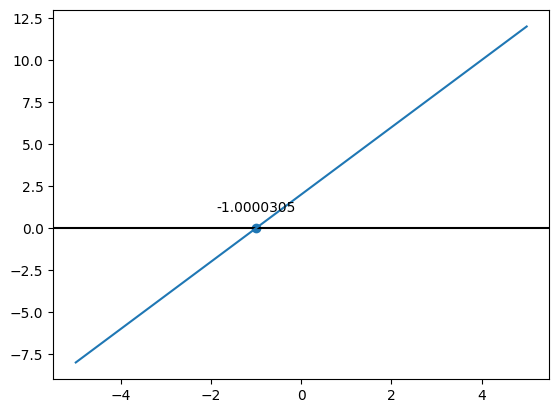

In [231]:
x = np.linspace(-5, 5)
y = np.vectorize(exemplo_linear)(x)
_ = plot.axhline(0, color="k")
_ = plot.plot(x, y)
_ = plot.scatter([res.x], [res.y])
_ = plot.text(res.x, 1, f"{res.x:{FORMATO_PADRAO}}", horizontalalignment="center")


## Exemplo Newton-Raphson

In [232]:
f = exemplo_poli
d = derivada_central(f)
res_1 = newton_raphson(f, d, -2, [criterio_x(10**-4)])
res_2 = newton_raphson(f, d, 4, [criterio_x(10**-4)])


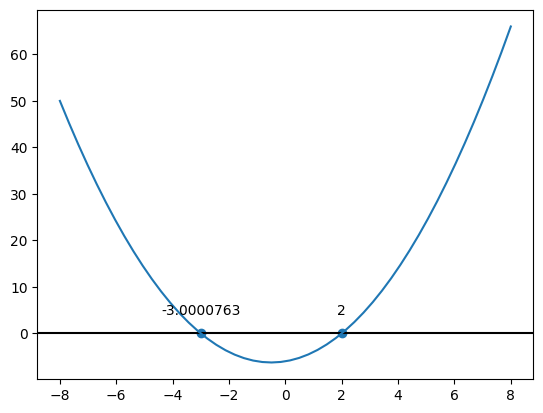

In [233]:
x = np.linspace(-8, 8)
y = np.vectorize(f)(x)
_ = plot.axhline(color="k")
_ = plot.plot(x, y)
_ = plot.scatter([res_1.x, res_2.x], [res_1.y, res_2.y])
_ = plot.text(res_1.x, 4, f"{res_1.x:{FORMATO_PADRAO}}", horizontalalignment="center")
_ = plot.text(res_2.x, 4, f"{res_2.x:{FORMATO_PADRAO}}", horizontalalignment="center")


## Exemplo solucionar linear

In [234]:
x = solucionar_linear(exemplo_b, exemplo_y)
print(x)


[0.2894248608534323, 0.2541743970315399, -0.1131725417439703]


## Exemplo Gauss-Seidel

In [235]:
x_inicial = [1.0, 1.0, 1.0]
res = gauss_seidel(exemplo_b, exemplo_y, x_inicial, [criterio_delta_x_vetor(10**-4)])
print(f"Solução {res.x} Encontrada em {res.i} passos")


Solução [0.28944322078332885, 0.25420971804947057, -0.11314490853281187] Encontrada em 21 passos


## Exemplo polinômio de Lagrange

In [236]:
f = polinomio_lagrange(exemplo_xs, exemplo_ys)


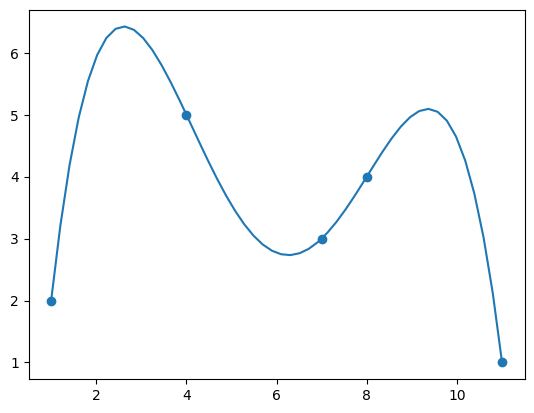

In [237]:
x = np.linspace(1, 11)
y = np.vectorize(f)(x)
_ = plot.scatter(exemplo_xs, exemplo_ys)
_ = plot.plot(x, y)


## Exemplo polinômio de Newton

In [238]:
coefs = coeficientes_polinomio_newton(exemplo_xs, exemplo_ys)
f = polinomio_newton(exemplo_xs, coefs)


In [239]:
display_latex(Latex(f"$f(x)={formula_polinomio_newton(exemplo_xs, coefs)}$"))


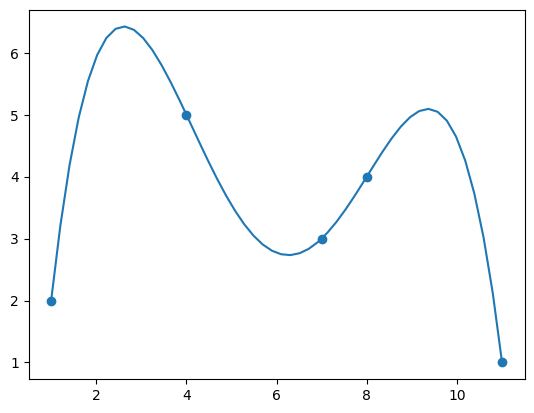

In [240]:
x = np.linspace(1, 11)
y = np.vectorize(f)(x)
_ = plot.scatter(exemplo_xs, exemplo_ys)
_ = plot.plot(x, y)


## Exemplo spline quadrática

In [241]:
lista_coefs = coeficientes_spline_quadratica(exemplo_xs, exemplo_ys, indice=1)
f = spline_quadratica(exemplo_xs, lista_coefs)


In [242]:
formulas = [formula_polinomio(coefs) for coefs in lista_coefs]
display_latex(Latex("\n\n".join(f"$f_{i}(x)={f}$" for i, f in enumerate(formulas))))


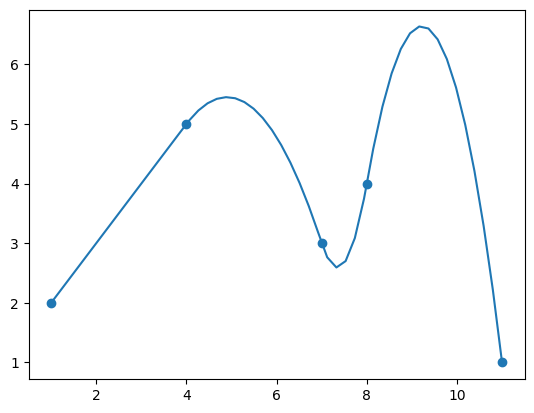

In [243]:
x = np.linspace(1, 11)
y = np.vectorize(f)(x)
_ = plot.scatter(exemplo_xs, exemplo_ys)
_ = plot.plot(x, y)


## Exemplo minimos quadrados 

In [244]:
fs = [lambda x: 1, lambda x: x, lambda x: x**2]
coefs = coeficientes_minimos_quadrados(exemplo_xs, exemplo_ys, fs)
f = minimos_quadrados(fs, coefs)


In [245]:
erro = soma_quadrado_residuos(exemplo_xs, exemplo_ys, f)
display_latex(Latex(f"erro: ${erro:{FORMATO_PADRAO}}$"))
display_latex(Latex(f"${formula_minimos_quadrados(coefs)}$"))


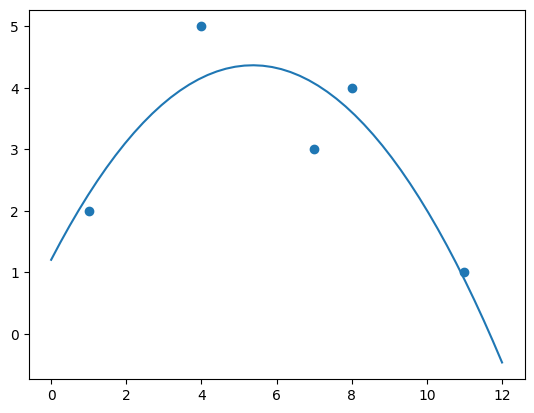

In [246]:
x = np.linspace(0, 12)
y = np.vectorize(f)(x)
_ = plot.scatter(exemplo_xs, exemplo_ys)
_ = plot.plot(x, y)


## Exemplo diferenciação numérica

In [247]:
pontos = list(range(-3, 4))
h = 1
ordem = 2
ordem_erro = ordem_erro_diferenca(len(pontos), ordem)
coefs, divisor = coeficientes_diferenca(pontos, ordem)


In [248]:
formula = formula_diferenca(pontos, ordem, coefs, divisor)
display(Latex(f"$$E = O(h^{ordem_erro})$$"))
display(Latex(f"$$\\frac{{\\partial f}}{{\\partial x}} \\approx {formula}$$"))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Exemplo derivação numérica

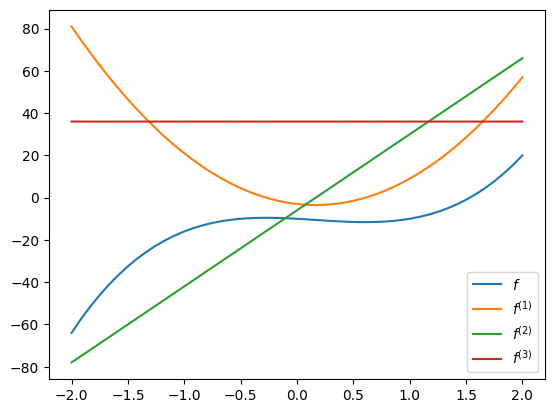

In [249]:
pontos = [-2, -1, 1, 2]
f = polinomio([-10, -3, -3, 6])
d_1 = derivada_numerica(f, pontos, 1)
d_2 = derivada_numerica(f, pontos, 2)
d_3 = derivada_numerica(f, pontos, 3)
xs = np.linspace(-2, 2)
ys_f = np.vectorize(f)(xs)
ys_d_1 = np.vectorize(d_1)(xs)
ys_d_2 = np.vectorize(d_2)(xs)
ys_d_3 = np.vectorize(d_3)(xs)
plot.plot(xs, ys_f)
plot.plot(xs, ys_d_1)
plot.plot(xs, ys_d_2)
plot.plot(xs, ys_d_3)
plot.legend(["$f$", "$f^{(1)}$", "$f^{(2)}$", "$f^{(3)}$"])


## Exemplo integração numérica

In [250]:
a = 0
b = 1
n = 10
valor = integracao_simpson_1_3_composta(exemplo_exp, a, b, n)
display_latex(Latex(f"$\\int_{a}^{b} f(x) dx = {valor:{FORMATO_PADRAO}}$"))


# Playground 

## 1

In [251]:
xs_questao = [1.0, 1.2, 1.4, 1.6, 1.8, 2]
ys_questao = [-0.306, -0.179, 0.059, 0.422, 0.921, 1.566]


### 1a

In [252]:
h = xs_questao[1] - xs_questao[0]
pontos = [-1, 0, 1]
ordem = 1
ordem_do_erro = ordem_erro_diferenca(len(pontos), ordem)
display(Latex(f"$h={h:{FORMATO_PADRAO}}$"))
display(Latex(f"$E = O(h^{ordem_do_erro})$"))

coefs, divisor = coeficientes_diferenca(pontos, ordem)
formula = formula_diferenca(pontos, ordem, coefs, divisor)
display(Latex(f"$\\frac{{df}}{{dx}}\\approx {formula}$"))

ys = ys_questao[1:4]
resultado = diferenca_finita(h, ordem, coefs, divisor, ys)
display(
    Latex(f"$f^{{({ordem})}}({xs_questao[2]})\\approx {resultado:{FORMATO_PADRAO}}$")
)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### 1b

In [253]:
pontos = [0, 1, 2, 3]
ordem = 2
ordem_do_erro = ordem_erro_diferenca(len(pontos), ordem)
display(Latex(f"$E=O(h^{ordem_do_erro})$"))

coefs, divisor = coeficientes_diferenca(pontos, ordem)
formula = formula_diferenca(pontos, ordem, coefs, divisor)
display(Latex(f"$\\frac{{df}}{{dx}}\\approx {formula}$"))

ys = ys_questao[0:4]
resultado = diferenca_finita(h, ordem, coefs, divisor, ys)
display(
    Latex(f"$f^{{({ordem})}}({xs_questao[0]})\\approx {resultado:{FORMATO_PADRAO}}$")
)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### 1c

In [254]:
pontos = [-3, -2, -1, 0]
ordem = 1
coefs, divisor = coeficientes_diferenca(pontos, ordem)
formula = formula_diferenca(pontos, ordem, coefs, divisor)
display(Latex(f"$\\frac{{df}}{{dx}}\\approx {formula}$"))

ys = ys_questao[2:6]
resultado = diferenca_finita(h, ordem, coefs, divisor, ys)
display(
    Latex(f"$f^{{({ordem})}}({xs_questao[5]})\\approx {resultado:{FORMATO_PADRAO}}$")
)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## 2

In [255]:
xs = [1.0, 1.25, 1.5, 1.75, 2.0]
ys = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
zs = [
    [0, 0.92, 1.81, 2.74, 3.75],
    [-0.53, 0.77, 1.93, 3.11, 4.37],
    [-1.34, 0.43, 1.93, 3.39, 4.91],
    [-2.5, -0.12, 1.78, 3.56, 5.38],
    [-4.03, -0.92, 1.46, 3.61, 5.74],
    [-6, -2, 0.94, 3.51, 6],
]


### 2a

In [259]:
x, y = 1.75, 1.6

pontos = [-1, 1]
h = zs[0][1] - zs[0][0]
ordem = 1
coefs, divisor = coeficientes_diferenca(pontos, ordem)

xi, yi = xs.index(x), ys.index(y)
amostra = [zs[yi][xi+p] for p in pontos]
resultado = diferenca_finita(h, ordem, coefs, divisor, amostra)
display(Latex(f"${notacao_derivada('g', ['x'])}({x},{y})\\approx {resultado:{FORMATO_PADRAO}}$"))

<IPython.core.display.Latex object>

In [260]:
x, y = 1.25, 1.8

pontos = [-1, 1]
h = zs[1][0] - zs[0][0]
ordem = 1
coefs, divisor = coeficientes_diferenca(pontos, ordem)

xi, yi = xs.index(x), ys.index(y)
amostra = [zs[yi+p][xi] for p in pontos]
resultado = diferenca_finita(h, ordem, coefs, divisor, amostra)
display(Latex(f"${notacao_derivada('g', ['y'])}({x},{y})\\approx {resultado:{FORMATO_PADRAO}}$"))

<IPython.core.display.Latex object>

### 2b

In [261]:
x, y = 1.5, 2.0

pontos = [-2, -1, 0]
h = zs[1][0] - zs[0][0]
ordem = 1
coefs, divisor = coeficientes_diferenca(pontos, 2)

xi, yi = xs.index(x), ys.index(y)
amostra = [zs[yi+p][xi] for p in pontos]
resultado = diferenca_finita(h, ordem, coefs, divisor, amostra)
display(Latex(f"${notacao_derivada('g', ['y', 'y'])}({x},{y})\\approx {resultado:{FORMATO_PADRAO}}$"))

<IPython.core.display.Latex object>